In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

In [26]:
def plot(confusion_matrix, model_name):
    plt.figure(figsize=(4, 3), dpi = 100)
    class_labels = ['None', 'Stage1', 'Stage2', 'Stage3']
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels,
                annot_kws={"fontweight": "bold"})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix of ' + str(model_name))
    plt.savefig("confusion_" + str(model_name) + '.png', transparent = True)

In [17]:
def metric(test_label, y_pred, model_name):
    cm = confusion_matrix(test_label, y_pred)
    cp = classification_report(test_label, y_pred)
    acc = accuracy_score(test_label, y_pred)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cp)
    print("Accuracy:", acc)
    plot(cm, model_name)

## Data Loading

In [3]:
raw_data = pd.read_csv('sph6004_assignment1_data.csv')
raw_data

,id,hospital_mortality,aki_stage,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,39553978,0,0,F,52.559969,WHITE,91.0,105.0,96.500000,82.0,...,NaN,173.0,173.0,14.0,6.0,4.0,4.0,0.0,152.0,39.4
1,39765666,0,0,F,76.486231,BLACK/AFRICAN AMERICAN,68.0,80.0,73.636364,130.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,76.2
2,37067082,0,0,F,55.881486,WHITE,78.0,106.0,93.200000,117.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,71.2
3,31205490,0,0,F,46.275517,WHITE,55.0,91.0,79.480000,73.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,157.0,72.2
4,37510196,1,2,F,77.018296,BLACK/AFRICAN AMERICAN,38.0,80.0,71.392857,93.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,157.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50915,32336619,0,0,M,43.884161,WHITE,76.0,110.0,87.758621,106.0,...,NaN,NaN,NaN,10.0,5.0,2.0,3.0,0.0,193.0,107.5
50916,31070865,0,0,M,82.773493,WHITE,63.0,96.0,71.000000,91.0,...,NaN,NaN,NaN,11.0,5.0,2.0,4.0,0.0,NaN,50.5
50917,36075953,0,0,F,48.022487,WHITE,93.0,109.0,100.423077,91.0,...,NaN,238.0,238.0,14.0,6.0,5.0,3.0,0.0,NaN,67.9
50918,38978960,1,2,M,58.694264,WHITE,71.0,100.0,84.666667,75.0,...,NaN,NaN,NaN,5.0,3.0,1.0,1.0,0.0,178.0,77.5


## Data Preprocessing

In [4]:
data_delete = raw_data.drop(['id', 'hospital_mortality'], axis=1)
data_delete

,aki_stage,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,0,F,52.559969,WHITE,91.0,105.0,96.500000,82.0,95.0,88.900000,...,NaN,173.0,173.0,14.0,6.0,4.0,4.0,0.0,152.0,39.4
1,0,F,76.486231,BLACK/AFRICAN AMERICAN,68.0,80.0,73.636364,130.0,158.0,142.454545,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,76.2
2,0,F,55.881486,WHITE,78.0,106.0,93.200000,117.0,151.0,135.320000,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,71.2
3,0,F,46.275517,WHITE,55.0,91.0,79.480000,73.0,115.0,97.760000,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,157.0,72.2
4,2,F,77.018296,BLACK/AFRICAN AMERICAN,38.0,80.0,71.392857,93.0,180.0,123.730769,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,157.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50915,0,M,43.884161,WHITE,76.0,110.0,87.758621,106.0,170.0,134.407407,...,NaN,NaN,NaN,10.0,5.0,2.0,3.0,0.0,193.0,107.5
50916,0,M,82.773493,WHITE,63.0,96.0,71.000000,91.0,152.0,114.227273,...,NaN,NaN,NaN,11.0,5.0,2.0,4.0,0.0,NaN,50.5
50917,0,F,48.022487,WHITE,93.0,109.0,100.423077,91.0,123.0,105.500000,...,NaN,238.0,238.0,14.0,6.0,5.0,3.0,0.0,NaN,67.9
50918,2,M,58.694264,WHITE,71.0,100.0,84.666667,75.0,129.0,104.636364,...,NaN,NaN,NaN,5.0,3.0,1.0,1.0,0.0,178.0,77.5


In [5]:
# Missing Rate
missing_rates = data_delete.isnull().mean()
counts_less_than_10 = (missing_rates < 0.1).sum()
counts_less_than_20 = (missing_rates < 0.2).sum()
counts_less_than_30 = (missing_rates < 0.3).sum()
counts_less_than_40 = (missing_rates < 0.4).sum()
counts_less_than_50 = (missing_rates < 0.5).sum()

print(f"Missing Rate < 10%: {counts_less_than_10}")
print(f"Missing Rate < 20%: {counts_less_than_20}")
print(f"Missing Rate < 30%: {counts_less_than_30}")
print(f"Missing Rate < 40%: {counts_less_than_40}")
print(f"Missing Rate < 50%: {counts_less_than_50}")

Missing Rate < 10%: 64
Missing Rate < 20%: 66
Missing Rate < 30%: 66
Missing Rate < 40%: 86
Missing Rate < 50%: 88


In [6]:
data_after_column = data_delete.loc[:, missing_rates < 0.3]
data_after_column.columns

Index(['aki_stage', 'gender', 'admission_age', 'race', 'heart_rate_min',
       'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean',
       'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean',
       'resp_rate_min', 'resp_rate_max', 'resp_rate_mean',
       'temperature_vital_min', 'temperature_vital_max',
       'temperature_vital_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_vital_min', 'glucose_vital_max', 'glucose_vital_mean',
       'hematocrit_lab_min', 'hematocrit_lab_max', 'hemoglobin_lab_min',
       'hemoglobin_lab_max', 'platelets_min', 'platelets_max', 'wbc_min',
       'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_lab_min',
       'bicarbonate_lab_max', 'bun_min', 'bun_max', 'calcium_lab_min',
       'calcium_lab_max', 'chloride_lab_min', 'chloride_lab_max',
       'creatinine_min', 'creatinine_max', 'glucose_lab_min',
       'glucose_lab_max', 'sodium_lab_min', 'sodium_lab_max',
       'potassium_lab_min', 'potassi

In [7]:
row_missing_ratio = data_after_column.isnull().mean(axis = 1)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results = {f'greater_than_{int(t*100)}%': data_after_column[row_missing_ratio > t] for t in thresholds}
for key, value in results.items():
    print(f"Rows with missing ratio {key}: {len(value)}")

Rows with missing ratio greater_than_10%: 1479
Rows with missing ratio greater_than_20%: 788
Rows with missing ratio greater_than_30%: 507
Rows with missing ratio greater_than_40%: 385
Rows with missing ratio greater_than_50%: 156
Rows with missing ratio greater_than_60%: 18
Rows with missing ratio greater_than_70%: 3


In [8]:
data_after_row = data_after_column[row_missing_ratio <= 0.1]

In [9]:
data_after_row.shape

(49441, 66)

In [10]:
# Recode Categorical Data

data_recode = data_after_row.copy()
data_recode['gender'] = pd.factorize(data_after_row['gender'])[0]
data_recode['race'] = pd.factorize(data_after_row['race'])[0]
data_recode

,aki_stage,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,0,0,52.559969,0,91.0,105.0,96.500000,82.0,95.0,88.900000,...,19.5,19.5,34.2,34.2,14.0,6.0,4.0,4.0,0.0,39.4
1,0,0,76.486231,1,68.0,80.0,73.636364,130.0,158.0,142.454545,...,11.5,14.5,24.9,69.6,15.0,6.0,5.0,4.0,0.0,76.2
2,0,0,55.881486,0,78.0,106.0,93.200000,117.0,151.0,135.320000,...,12.1,12.6,33.1,36.6,15.0,6.0,5.0,4.0,0.0,71.2
3,0,0,46.275517,0,55.0,91.0,79.480000,73.0,115.0,97.760000,...,11.0,11.3,29.4,31.8,15.0,6.0,5.0,4.0,0.0,72.2
4,2,0,77.018296,1,38.0,80.0,71.392857,93.0,180.0,123.730769,...,13.5,15.3,21.3,150.0,15.0,1.0,0.0,1.0,1.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50915,0,1,43.884161,0,76.0,110.0,87.758621,106.0,170.0,134.407407,...,13.1,13.1,23.3,23.3,10.0,5.0,2.0,3.0,0.0,107.5
50916,0,1,82.773493,0,63.0,96.0,71.000000,91.0,152.0,114.227273,...,13.1,13.6,22.8,31.0,11.0,5.0,2.0,4.0,0.0,50.5
50917,0,0,48.022487,0,93.0,109.0,100.423077,91.0,123.0,105.500000,...,13.0,13.0,20.7,20.7,14.0,6.0,5.0,3.0,0.0,67.9
50918,2,1,58.694264,0,71.0,100.0,84.666667,75.0,129.0,104.636364,...,14.1,14.1,29.3,29.3,5.0,3.0,1.0,1.0,0.0,77.5


In [11]:
# Data Split & Imputation
train_missing_df, test_missing_df = train_test_split(data_recode, test_size=0.2, random_state=42)
median_values = train_missing_df.median()
train_df = train_missing_df.fillna(median_values)
test_df = test_missing_df.fillna(median_values)

train_data = train_df.drop('aki_stage', axis = 1)
train_label = train_df['aki_stage']
test_data = test_df.drop('aki_stage', axis = 1)
test_label = test_df['aki_stage']

## Feature Selection

### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(train_data, train_label)

RandomForestClassifier(random_state=42)

In [13]:
y_pred = rf.predict(test_data)
y_score = rf.predict_proba(test_data)
cm = confusion_matrix(test_label, y_pred)
cp = classification_report(test_label, y_pred)
acc = accuracy_score(test_label, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cp)
print("Accuracy:", acc)

Confusion Matrix:
 [[2113   53  942  105]
 [ 786   52  910  182]
 [ 871   49 2031  243]
 [ 192   23  721  616]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.66      0.59      3213
           1       0.29      0.03      0.05      1930
           2       0.44      0.64      0.52      3194
           3       0.54      0.40      0.46      1552

    accuracy                           0.49      9889
   macro avg       0.45      0.43      0.40      9889
weighted avg       0.46      0.49      0.44      9889

Accuracy: 0.48660127414298715


In [14]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = train_data.columns
for f in range(train_data.shape[1]):
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) weight_admit                   0.031749
 2) admission_age                  0.026862
 3) creatinine_max                 0.026359
 4) bun_max                        0.021592
 5) creatinine_min                 0.021508
 6) bun_min                        0.020724
 7) sbp_min                        0.019581
 8) ptt_max                        0.019539
 9) pt_max                         0.019190
10) resp_rate_mean                 0.018858
11) spo2_mean                      0.018733
12) glucose_vital_max              0.018370
13) temperature_vital_mean         0.017959
14) sbp_mean                       0.017935
15) heart_rate_mean                0.017933
16) wbc_max                        0.017797
17) ptt_min                        0.017739
18) dbp_mean                       0.017698
19) platelets_min                  0.017516
20) glucose_lab_max                0.017478
21) platelets_max                  0.017336
22) sbp_max                        0.017238
23) wbc_min                     

### Lasso Regression

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [19:01<00:00,  5.71s/it]


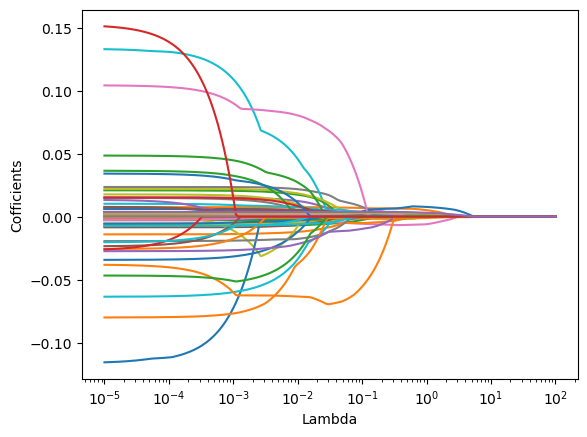

In [15]:
Lambdas = np.logspace(-5, 2, 200)
lasso_cofficients = []
for Lambda in tqdm(Lambdas):
    lasso = Lasso(alpha = Lambda, max_iter = 1000)
    lasso.fit(train_data, train_label)
    lasso_cofficients.append(lasso.coef_)
plt.plot(Lambdas, lasso_cofficients)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Cofficients')
plt.show()

In [16]:
lasso_cv = LassoCV(alphas = Lambdas, cv = 10, max_iter = 10000)
lasso_cv.fit(train_data, train_label)
lasso_best_alpha = lasso_cv.alpha_
print(lasso_best_alpha)

0.004713753134116724


In [17]:
pd.set_option('display.max_rows', None)
lasso = Lasso(alpha = lasso_best_alpha, max_iter = 10000)
lasso.fit(train_data, train_label)
res = pd.Series(index = ['Intercept'] + train_data.columns.tolist(), data=[lasso.intercept_] + lasso.coef_.tolist())
res = res.abs().sort_values(ascending = False)
print(res)
lasso_predict = lasso.predict(test_data)

Intercept                 1.954244e+00
creatinine_max            8.343878e-02
gcs_verbal                6.278850e-02
temperature_vital_max     6.203179e-02
calcium_lab_min           6.112026e-02
hemoglobin_lab_min        4.891291e-02
gcs_eyes                  4.217362e-02
potassium_lab_max         3.334519e-02
temperature_vital_min     2.491778e-02
chloride_lab_max          2.448692e-02
hemoglobin_lab_max        2.317113e-02
resp_rate_mean            2.284302e-02
gcs_motor                 2.152329e-02
bicarbonate_lab_max       2.047163e-02
spo2_max                  1.919796e-02
bicarbonate_lab_min       1.816459e-02
calcium_lab_max           1.791092e-02
mbp_mean                  1.391086e-02
hematocrit_lab_max        1.352755e-02
dbp_mean                  1.306016e-02
chloride_lab_min          1.214110e-02
hematocrit_lab_min        9.910787e-03
bun_min                   8.182401e-03
resp_rate_min             7.666669e-03
admission_age             7.560092e-03
race                     

In [18]:
# combined feature importance
rf_importances = pd.Series(importances[indices], index=feat_labels[indices])
rf_ranks = rf_importances.rank(method = 'min', ascending = False)
lasso_ranks = res.rank(method = 'min', ascending = False)
combined_ranks = rf_ranks + lasso_ranks
final_ranks = combined_ranks.sort_values()
final_ranks

creatinine_max              5.0
resp_rate_mean             22.0
admission_age              27.0
bun_min                    29.0
temperature_vital_max      33.0
weight_admit               37.0
dbp_mean                   38.0
bun_max                    39.0
hemoglobin_lab_min         44.0
mbp_mean                   44.0
sbp_mean                   44.0
sbp_min                    45.0
potassium_lab_max          47.0
calcium_lab_min            48.0
heart_rate_mean            48.0
ptt_max                    48.0
temperature_vital_min      50.0
hematocrit_lab_min         50.0
hematocrit_lab_max         51.0
pt_max                     51.0
hemoglobin_lab_max         51.0
spo2_mean                  52.0
sbp_max                    56.0
chloride_lab_max           59.0
gcs_verbal                 60.0
heart_rate_max             62.0
calcium_lab_max            62.0
heart_rate_min             63.0
creatinine_min             64.0
wbc_max                    64.0
platelets_min              65.0
mbp_min 

In [19]:
pd.reset_option('display.max_rows')

In [20]:
features_selected = final_ranks[final_ranks < 50].index
print("Selected Features:", features_selected)

Selected Features: Index(['creatinine_max', 'resp_rate_mean', 'admission_age', 'bun_min',
       'temperature_vital_max', 'weight_admit', 'dbp_mean', 'bun_max',
       'hemoglobin_lab_min', 'mbp_mean', 'sbp_mean', 'sbp_min',
       'potassium_lab_max', 'calcium_lab_min', 'heart_rate_mean', 'ptt_max'],
      dtype='object')


In [21]:
selected_train_data = train_data[features_selected]
selected_test_data = test_data[features_selected]

In [22]:
selected_train_data.to_csv('selected_train_data.csv')
selected_test_data.to_csv('selected_test_data.csv')
train_label.to_csv('train_label.csv')
test_label.to_csv('test_label.csv')

## Model

In [15]:
selected_train_data = pd.read_csv('selected_train_data.csv')
del selected_train_data['Unnamed: 0']
selected_test_data = pd.read_csv('selected_test_data.csv')
del selected_test_data['Unnamed: 0']
train_label = pd.read_csv('train_label.csv')
del train_label['Unnamed: 0']
test_label = pd.read_csv('test_label.csv')
del test_label['Unnamed: 0']

### Decision Tree Classifier

Confusion Matrix:
 [[1346  671  908  288]
 [ 590  445  632  263]
 [ 841  664 1199  490]
 [ 317  286  449  500]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.42      0.43      3213
           1       0.22      0.23      0.22      1930
           2       0.38      0.38      0.38      3194
           3       0.32      0.32      0.32      1552

    accuracy                           0.35      9889
   macro avg       0.34      0.34      0.34      9889
weighted avg       0.36      0.35      0.35      9889

Accuracy: 0.35291738295075337


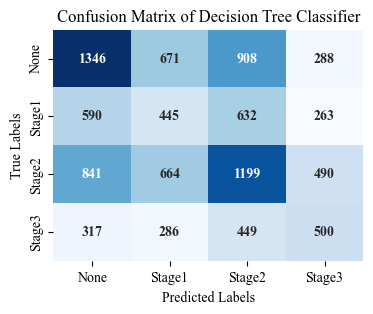

In [27]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(selected_train_data, train_label)
predictions = clf.predict(selected_test_data)
metric(test_label, predictions, 'Decision Tree Classifier')

### Random Forest Classifier

Confusion Matrix:
 [[2042   69  987  115]
 [ 788   69  890  183]
 [ 935   85 1922  252]
 [ 217   29  702  604]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.64      0.57      3213
           1       0.27      0.04      0.06      1930
           2       0.43      0.60      0.50      3194
           3       0.52      0.39      0.45      1552

    accuracy                           0.47      9889
   macro avg       0.43      0.42      0.39      9889
weighted avg       0.44      0.47      0.43      9889

Accuracy: 0.4689048437658004


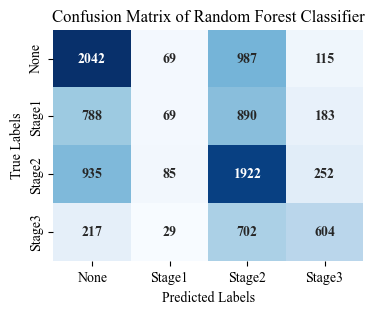

In [29]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(selected_train_data, train_label)
predictions = rf.predict(selected_test_data)
metric(test_label, predictions, 'Random Forest Classifier')

### Support Vector Machine

Confusion Matrix:
 [[2058    4 1044  107]
 [ 779   13  987  151]
 [ 861    7 2142  184]
 [ 237    4  766  545]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.64      0.58      3213
           1       0.46      0.01      0.01      1930
           2       0.43      0.67      0.53      3194
           3       0.55      0.35      0.43      1552

    accuracy                           0.48      9889
   macro avg       0.49      0.42      0.39      9889
weighted avg       0.49      0.48      0.43      9889

Accuracy: 0.4811406613408838


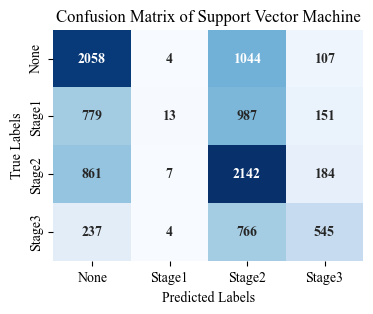

In [30]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(selected_train_data)
test_scaled = scaler.transform(selected_test_data)

svm = SVC(kernel = 'rbf', random_state = 42, max_iter = 10000)
svm.fit(train_scaled, train_label.values.ravel())
predictions = svm.predict(test_scaled)
metric(test_label, predictions, 'Support Vector Machine')

### AdaBoost

Confusion Matrix:
 [[2031   14 1042  126]
 [ 829   15  912  174]
 [ 974   17 1947  256]
 [ 260   20  674  598]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.63      0.56      3213
           1       0.23      0.01      0.02      1930
           2       0.43      0.61      0.50      3194
           3       0.52      0.39      0.44      1552

    accuracy                           0.46      9889
   macro avg       0.42      0.41      0.38      9889
weighted avg       0.42      0.46      0.41      9889

Accuracy: 0.4642532106380827


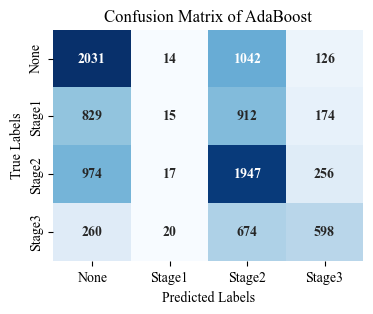

In [31]:
ada = AdaBoostClassifier(n_estimators = 100, random_state = 42)
ada.fit(selected_train_data, train_label)
predictions = ada.predict(selected_test_data)
metric(test_label, predictions, 'AdaBoost')

### XGBoost

Confusion Matrix:
 [[2021   92  984  116]
 [ 793   92  869  176]
 [ 846  106 1944  298]
 [ 228   41  653  630]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.63      0.57      3213
           1       0.28      0.05      0.08      1930
           2       0.44      0.61      0.51      3194
           3       0.52      0.41      0.45      1552

    accuracy                           0.47      9889
   macro avg       0.44      0.42      0.40      9889
weighted avg       0.45      0.47      0.44      9889

Accuracy: 0.47396096673071086


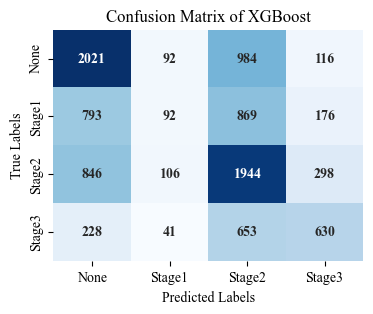

In [32]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss', random_state = 42)
xgb.fit(selected_train_data, train_label)
predictions = xgb.predict(selected_test_data)
metric(test_label, predictions, 'XGBoost')

### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 39552, number of used features: 16
[LightGBM] [Info] Start training from score -1.134913
[LightGBM] [Info] Start training from score -1.636656
[LightGBM] [Info] Start training from score -1.123106
[LightGBM] [Info] Start training from score -1.841043
Confusion Matrix:
 [[2043   42 1006  122]
 [ 793   47  915  175]
 [ 869   48 2004  273]
 [ 223   24  665  640]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.64      0.57      3213
           1       0.29      0.02      0.04      1930
           2       0.44      0.63      0.51      3194
           3       0.53      0.41      0.46      1552

    accuracy           

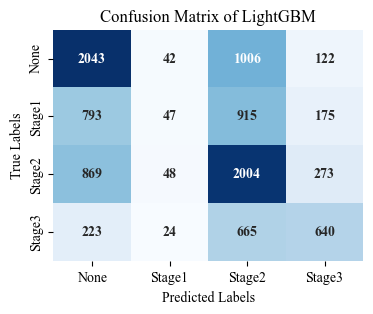

In [33]:
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(selected_train_data, train_label)
predictions = lgbm.predict(selected_test_data)
metric(test_label, predictions, 'LightGBM')

### Gradient Boosting Classifier

Confusion Matrix:
 [[2042   14 1035  122]
 [ 810   12  942  166]
 [ 880    8 2045  261]
 [ 234   10  682  626]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.64      0.57      3213
           1       0.27      0.01      0.01      1930
           2       0.43      0.64      0.52      3194
           3       0.53      0.40      0.46      1552

    accuracy                           0.48      9889
   macro avg       0.44      0.42      0.39      9889
weighted avg       0.44      0.48      0.43      9889

Accuracy: 0.4778036201840429


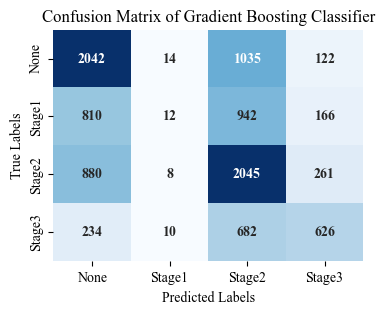

In [34]:
gb = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
gb.fit(selected_train_data, train_label)
predictions = gb.predict(selected_test_data)
metric(test_label, predictions, 'Gradient Boosting Classifier')

### Multinomial Logistic Regression

Confusion Matrix:
 [[2035   12 1081   85]
 [ 828   12  963  127]
 [ 947    9 2071  167]
 [ 289   32  758  473]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.63      0.56      3213
           1       0.18      0.01      0.01      1930
           2       0.42      0.65      0.51      3194
           3       0.56      0.30      0.39      1552

    accuracy                           0.46      9889
   macro avg       0.42      0.40      0.37      9889
weighted avg       0.42      0.46      0.41      9889

Accuracy: 0.4642532106380827


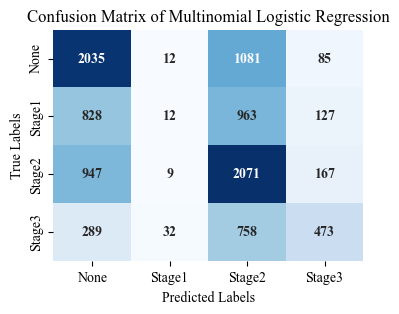

In [35]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 1000)
lr.fit(selected_train_data, train_label)
predictions = lr.predict(selected_test_data)
metric(test_label, predictions, 'Multinomial Logistic Regression')

### Multilayer Perceptron

Confusion Matrix:
 [[1674   13 1424  102]
 [ 593   24 1144  169]
 [ 646    6 2277  265]
 [ 162   22  810  558]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.52      0.53      3213
           1       0.37      0.01      0.02      1930
           2       0.40      0.71      0.51      3194
           3       0.51      0.36      0.42      1552

    accuracy                           0.46      9889
   macro avg       0.46      0.40      0.37      9889
weighted avg       0.46      0.46      0.41      9889

Accuracy: 0.45838810799878654


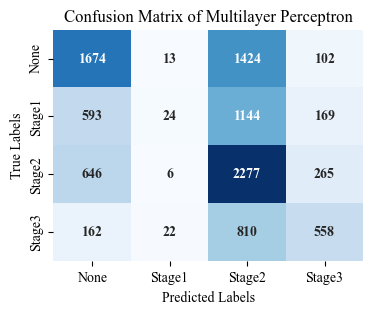

In [36]:
mlp = MLPClassifier(random_state = 42, max_iter = 1000)
mlp.fit(selected_train_data, train_label)
predictions = mlp.predict(selected_test_data)
metric(test_label, predictions, 'Multilayer Perceptron')